In [1]:
from tqdm import tqdm
from typing import List, Dict, Any, Union
from pydantic import BaseModel
from lancedb.pydantic import LanceModel, Vector
import pandas as pd
from lancedb.embeddings.utils import api_key_not_found_help
from lancedb.embeddings.registry import register
from lancedb.embeddings import TextEmbeddingFunction, get_registry
import numpy as np
from functools import cached_property
from openai import AzureOpenAI
from azure_openai.setup import AzureOpenAiConfig
import nest_asyncio
import lancedb
from azure.identity import DefaultAzureCredential
import logging
import asyncio
import sys
import os

# Add parent directory to path
current_dir = os.path.dirname(os.path.abspath(__name__))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

## LanceDBManager

IT is responsible for all interactions with the blob storage


before that we need a lancedb embedder.

### LanceDBEmbedder

It is responsible for all interactions with the tables.
there is a built in one but it had issues and could not be used. luckily we could make a custom one.

the problem with the built in one is that it does not support the following:

- microsoft ad authentication for enterprises

it worked fine for a normal user if you dint have to go through azure ad.


In [2]:

openai_config = AzureOpenAiConfig()
credentials = DefaultAzureCredential()
token_provdier = openai_config.get_token_provider(DefaultAzureCredential())

# make the custom embedder function caus ethe one provided by lancedb is not working


@register("azure_openai")
class AzureOpenAIEmbeddings(TextEmbeddingFunction):
    """
    An embedding function that uses the Azure OpenAI API
    """

    name: str = openai_config.text_embedder_lagre.deployment_name
    azure_api_key: str = openai_config.get_openai_api_key(
        credential=credentials)
    azure_endpoint: str = openai_config.endpoint
    azure_deployment: str = openai_config.text_embedder_lagre.deployment_name
    azure_api_version: str = openai_config.text_embedder_lagre.api_version

    def ndims(self):
        return self._ndims

    @cached_property
    def _ndims(self):
        if self.name == openai_config.text_embedder_lagre.deployment_name:
            return openai_config.text_embedder_lagre.ndims
        else:
            raise ValueError(f"Unknown model name {self.name}")

    def ndims(self):
        """
        Return the dimensionality of the embeddings.
        """
        if self.name == openai_config.text_embedder_lagre.deployment_name:
            return self._ndims
        else:
            raise ValueError(f"Unknown model name {self.name}")

    def generate_embeddings(
        self, texts: Union[List[str], np.ndarray]
    ) -> List[np.array]:
        """
        Get the embeddings for the given texts

        Parameters
        ----------
        texts: list[str] or np.ndarray (of str)
            The texts to embed
        """
        # TODO retry, rate limit, token limit
        if self.name == openai_config.text_embedder_lagre.deployment_name:
            rs = self._azure_openai_client.embeddings.create(
                input=texts, model=self.name)
        else:
            rs = self._azure_openai_client.embeddings.create(
                input=texts, model=self.name, dimensions=self.ndims()
            )
        return [v.embedding for v in rs.data]

    @cached_property
    def _azure_openai_client(self):
        if not os.environ.get("OPENAI_API_KEY") and not self.azure_api_key:
            api_key_not_found_help("openai")
        return AzureOpenAI(
            azure_endpoint=openai_config.endpoint,
            # azure_ad_token_provider=token_provdier,
            api_version=openai_config.api_version,
            api_key=openai_config.get_openai_api_key(DefaultAzureCredential()),
            max_retries=5,
        )


embedder = get_registry().get("azure_openai").create()

def get_embedder():
    return get_registry().get("azure_openai").create()


to check how to use and what you get back we have a test bellow


In [3]:
# Generate embeddings for a list of texts TEST

embeddings = embedder.generate_embeddings(["hello world", "goodbye world"])
# Convert embeddings into a pandas DataFrame
embeddings_df = pd.DataFrame(
    embeddings, columns=[f"dim_{i}" for i in range(len(embeddings[0]))])
embeddings_df.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_3062,dim_3063,dim_3064,dim_3065,dim_3066,dim_3067,dim_3068,dim_3069,dim_3070,dim_3071
0,-0.002786,-0.022649,0.005107,0.026940,0.015299,0.009778,-0.005585,0.085468,0.011564,0.047623,...,-0.001351,0.007141,-0.017521,0.003406,0.003008,0.002577,0.001279,0.015119,0.001032,-0.003605
1,-0.040522,-0.031269,0.004365,0.023705,-0.010782,0.034536,0.012536,0.066818,0.004377,0.025910,...,-0.004800,0.036563,0.008642,0.005443,-0.023126,-0.002327,-0.003080,0.001875,0.012593,0.001872


### Model

we need them to store the data in the tables. it checks if the data is valid and if it is not it will throw an error.

the important one was the vector dimensions. lance db will block you if you try to store a vector with a different dimension than the one you have specified when creating the table.

this means if we move to a different model we might have to change the table. possibly recreate it.

!!! note
for some reason lancedb couldnt accecpt a pydantic model with a list of dictionaries. so we had to use a list of strings instead.

    also how you handle dictionaries is they have to be provided as a BaseModel. so you have to create a model for the dictionary and then use that model in the main model.


In [22]:
class User(LanceModel):
    email: str
    name: str
    query: str = embedder.SourceField()  # Queries associated with the user
    # Embedding vector for semantic searches
    vector: Vector(embedder.ndims()) = embedder.VectorField()
    newsletter: bool  # Whether the user is subscribed to the newsletter
    # TODO: Decide if we want to use the sources here, or if we want to use the users in the content schema. We don't need both.
    sources: List[str] = Field(default_factory=list) # List of sources associated with the user. the ones the user is interested in seeing content from
    saved_content: List[str]  = Field(default_factory=list)  # List of content ids saved by the user

    class Config:
        arbitrary_types_allowed = True


# Content Schema
class Content(LanceModel):
    # Unique identifier for content (hash combined), e.g hash(title + source) SHA256
    content_id: str
    title: str  # Title of the content
    text: str = embedder.SourceField()  # Main text of the content
    # Semantic embedding of the content
    vector: Vector(embedder.ndims()) = embedder.VectorField()
    image_url: str
    image_description: str
  # Image URL and description
    publication_date: str  # ISO 8601 format
    source: str  # Source of the content, full url
    users: List[str] = Field(default_factory=list)  # List of user ids (email) that are interested in the content

    class Config:
        arbitrary_types_allowed = True


# Label Schema
class Label(LanceModel):
    # Unique identifier for the label (hash combined) e.g hash(name + email) SHA256
    label_id: str
    name: str  # Label name
    email: str  # Associated email
    description: str = embedder.SourceField()  # Description of the label
    # Semantic embedding of the label
    vector: Vector(embedder.ndims()) = embedder.VectorField()

    class Config:
        arbitrary_types_allowed = True


# Content-Label Mapping Schema
class ContentLabel(LanceModel):
    content_label_id: str  # Unique identifier for the mapping
    content_id: str  # Foreign key to content
    label_id: str  # Foreign key to label
    active: bool = True  # Soft delete flag to indicate if the label is active or not

    class Config:
        arbitrary_types_allowed = True

In [23]:

# nest_asyncio.apply()

# # Create Azure Credentials
# credentials = DefaultAzureCredential()
# azure_credentials = {
#     "azure_storage_account_name": "sadevlocalnewsai",
#     "azure_tenant_id": "35971640-5c41-4de2-9579-823a95d4291e",
#     "azure_storage_token": credentials.get_token(
#         "https://storage.azure.com/.default"
#     ).token,
# }


def get_lance_db_azure_credentials(credentials: DefaultAzureCredential = DefaultAzureCredential()):
    return {
        "azure_storage_account_name": "sadevlocalnewsai",
        "azure_tenant_id": "35971640-5c41-4de2-9579-823a95d4291e",
        "azure_storage_token": credentials.get_token(
            "https://storage.azure.com/.default"
        ).token,
    }


class LanceDBManager:
    def __init__(
        self,
        database_url: str = "az://dev-vector-db/",
        azure_credentials: Dict[str, Any] = get_lance_db_azure_credentials(),
        embedder: TextEmbeddingFunction = embedder,
        async_mode: bool = True,
    ):
        """
        Initialize LanceDBManager with the database URL, Azure credentials, and an embedder.

        Args:
            database_url (str): The path or URL to the LanceDB database.
            azure_credentials (dict): Azure storage credentials.
            embedder (TextEmbeddingFunction): Embedder instance for generating embeddings.
        """
        self.database_url = database_url
        self.azure_credentials = azure_credentials
        self.embedder = embedder
        self.async_mode = async_mode

    def get_sync_manager(self):
        return lancedb.connect(self.database_url, storage_options=self.azure_credentials)

    @property
    async def connection(self):
        """
        Establish a connection to the LanceDB database.

        Returns:
            An asynchronous connection object to LanceDB.
        """
        import lancedb

        return await lancedb.connect_async(
            uri=self.database_url,
            storage_options=self.azure_credentials
        )

    @property
    async def table_names(self):
        """
        Retrieve a list of table names in the database.

        Returns:
            List of table names.
        """
        try:
            connection = await self.connection
            return await connection.table_names()
        finally:
            connection.close()

    async def get_table(self, table_name: str):
        """
        Get a table object from the database.

        Args:
            table_name (str): Name of the table to retrieve.

        Returns:
            Table: LanceDB table object.
        """
        try:
            connection = await self.connection
            return await connection.open_table(table_name)
        except Exception as e:
            logging.error(f"Error getting table '{table_name}': {e}")
            raise

    async def create_schema(self, table_name: str, schema: Any):
        """
        Create a schema-based table in LanceDB.

        Args:
            table_name (str): Name of the table.
            schema (Any): Schema of the table.
        """
        try:
            connection = await self.connection
            table = await connection.create_table(
                table_name, schema=schema, exist_ok=True
            )

            # Example: Adding sample data for testing
            sample_data = [{"text": "hello world"}, {"text": "goodbye world"}]
            existing_rows = await table.to_pandas()
            existing_texts = (
                set(existing_rows["text"]
                    ) if "text" in existing_rows.columns else set()
            )

            # Avoid adding duplicates
            new_data = [row for row in sample_data if row["text"]
                        not in existing_texts]
            if new_data:
                await table.add(new_data)

            query = "greetings"
            results = await self.vector_search(table_name, query)
            print(f"Search results for query '{query}': {results}")

        except Exception as e:
            logging.error(f"Error creating schema for table '{
                          table_name}': {e}")
            raise
        finally:
            connection.close()

    async def create_table(self, table_name: str, schema: Any, overwrite: bool = False):
        """
        Create a new table in LanceDB.

        Args:
            table_name (str): Name of the table.
            schema (Any): Schema of the table.
            overwrite (bool): Whether to overwrite the table if it exists.
        """
        try:
            connection = await self.connection
            mode = "overwrite" if overwrite else "create"
            await connection.create_table(table_name, schema=schema, mode=mode)
            logging.info(f"Table '{table_name}' created successfully.")
        except Exception as e:
            logging.error(f"Error creating table '{table_name}': {e}")
        finally:
            connection.close()

    async def add_data(
        self, table_name: str, data: List[Dict[str, Any]], unique_field: str
    ):
        """
        Add data to a LanceDB table, avoiding duplicates based on specified unique fields.

        Args:
            table_name (str): Name of the table.
            data (List[Dict[str, Any]]): List of data entries to add.
            unique_fields (List[str]): List of fields to use for uniqueness checks.

        Returns:
            int: Number of rows added.
        """
        if not unique_field:
            raise ValueError(
                "Unique field must be specified to check for duplicates.")

        try:
            connection = await self.connection
            async_table = await connection.open_table(table_name)

            # The merge_insert function fails if the table is empty
            if await async_table.count_rows() == 0:
                await async_table.add(data)
                logging.info(f"Added {len(data)} entries to table '{
                             table_name}'.")
                return len(data)

            else:
                rows_before = await async_table.count_rows()
                await async_table.merge_insert(on=unique_field).when_not_matched_insert_all().execute(data)
                rows_after = await async_table.count_rows()
                new_rows = rows_after - rows_before
                logging.info(f"Added {new_rows} new entries to table '{
                             table_name}'.")
            return new_rows
        except Exception as e:
            logging.error(f"Error adding data to table '{table_name}': {e}")
            raise
        finally:
            connection.close()

    async def update_data(
        self, table_name: str, data: List[Dict[str, Any]], unique_field: str
    ):
        """
        Update data in a LanceDB table based on specified unique fields. Using the merge_insert with the when_matched_update_all() function
        """
        if not unique_field:
            raise ValueError(
                "Unique field must be specified to check for duplicates.")

        try:
            connection = await self.connection
            async_table = await connection.open_table(table_name)

            if await async_table.count_rows() == 0:
                await async_table.add(data)
                logging.info(f"Added {len(data)} entries to table '{
                             table_name}'.")
                return len(data)

            else:
                await async_table.merge_insert(on=unique_field).when_matched_update_all().execute(data)
                logging.info(f"Updated {len(data)} entries in table '{
                             table_name}'.")
                return len(data)

        except Exception as e:
            logging.error(f"Error updating data in table '{table_name}': {e}")
            raise
        finally:
            connection.close()

    async def fetch_data(
        self,
        table_name: str,
        as_pandas: bool = True,
        page: int = 1,
        per_page: int = 10,
        filter: str = None,
        columns_to_exclude: List[str] = [],
    ):
        """
        Fetch data from a LanceDB table with pagination and optional filtering.

        Args:
            table_name (str): Name of the table.
            as_pandas (bool): Whether to return data as a pandas DataFrame.
            page (int): Page number for pagination.
            per_page (int): Number of items per page. Use -1 to fetch all data.
            filter (str): SQL filter expression. these are the filters that can be used - https://lancedb.github.io/lancedb/sql/#sql-filters
            columns_to_exclude (List[str]): List of columns to exclude from the results.

        Returns:
            DataFrame or List[Dict]: Fetched data.
            List[Dict]: Fetched data as a list of dictionaries if as_pandas is set to False.
        """
        # docs used to make this function: https://lancedb.github.io/lancedb/sql/#pre-and-post-filtering
        try:
            connection = await self.connection
            async_table = await connection.open_table(table_name)
            query = async_table.query()

            # dont include the vector column in the results .select(["title", "text", "_distance"]) is used to define the columns to be returned
            # !DANGER The paranthesis around async_table.to_pandas() is used to make sure that the head function is called on the dataframe and not coroutine
            table_df = (await async_table.to_pandas()).head(1).columns

            columns_to_include = [
                col for col in table_df if col not in columns_to_exclude
            ]

            query = query.select(columns_to_include).with_row_id()

            # the "await async_table.count_rows()" is done like that beacause there is a bug in lancedb v0.17.0 that does not respect the limit(-1) when used with where clause
            # https://github.com/lancedb/lancedb/issues/1852
            if filter:
                query = (
                    query.where(filter).limit(
                        per_page).offset((page - 1) * per_page)
                    if per_page != -1
                    else query.where(filter).limit(await async_table.count_rows())
                )
            else:
                query = (
                    query.limit(per_page).offset((page - 1) * per_page)
                    if per_page != -1
                    else query.limit(await async_table.count_rows())
                )
            df = await query.to_pandas()
            return df if as_pandas else df.to_dict(orient="records")
        except Exception as e:
            logging.error(f"Error fetching data from table '{
                          table_name}': {e}")
            raise
        finally:
            connection.close()

    async def vector_search(
        self,
        table_name: str,
        query: str,
        limit: int = 5,
        as_pandas: bool = True,
        columns_to_exclude: List[str] = [],
    ):
        """
        Perform a vector search on a LanceDB table.

        Args:
            table_name (str): Name of the table.
            query (str): Query text to search for.
            limit (int): Number of search results to return.
            as_pandas (bool): Whether to return data as a pandas DataFrame.
            columns_to_exclude (List[str]): List of columns to exclude from the results.

        Returns:
            DataFrame: Search results.
            List[Dict]: Search results as a list of dictionaries. if as_pandas is set to False
        """
        try:
            connection = await self.connection
            async_table = await connection.open_table(table_name)

            # dont include the vector column in the results .select(["title", "text", "_distance"]) is used to define the columns to be returned
            # !DANGER The paranthesis around async_table.to_pandas() is used to make sure that the head function is called on the dataframe and not coroutine
            table_df = (await async_table.to_pandas()).head(3).columns

            columns_to_include = [
                col for col in table_df if col not in columns_to_exclude
            ]

            # Generate embedding for the query
            embedding = self.embedder.generate_embeddings([query])[0]

            # Perform vector search
            # results = await async_table.vector_search(embedding).limit(limit).to_pandas()
            results = (
                await async_table.query()
                .select(columns_to_include)
                .with_row_id()
                .nearest_to(embedding)
                .limit(limit)
                .to_pandas()
            )

            return results if as_pandas else results.to_dict(orient="records")
        except Exception as e:
            logging.error(
                f"Error performing vector search on table '{table_name}': {e}"
            )
            raise
        finally:
            connection.close()

    async def delete_table(self, table_name: str):
        """
        Delete a table from LanceDB.

        Args:
            table_name (str): Name of the table to delete.
        """
        try:
            connection = await self.connection
            await connection.drop_table(table_name)
            logging.info(f"Table '{table_name}' deleted successfully.")
            return True
        except Exception as e:
            logging.error(f"Error deleting table '{table_name}': {e}")
            raise
        finally:
            connection.close()

    async def delete_rows(self, table_name: str, condition: str):
        """
        Delete rows from a table based on a condition.

        Args:
            table_name (str): Name of the table.
            condition (str): Condition to match rows for deletion.
        """
        try:
            connection = await self.connection
            async_table = await connection.open_table(table_name)
            await async_table.delete(where=condition)
            logging.info(
                f"Rows matching condition '{condition}' deleted from table '{
                    table_name
                }'."
            )
        except Exception as e:
            logging.error(f"Error deleting rows from table '{
                          table_name}': {e}")
            raise
        finally:
            connection.close()

    async def delete_duplicates(self, table_name: str, subset: List[str]):
        """
        Remove duplicate rows from a LanceDB table based on specified columns.

        Args:
            table_name (str): Name of the table.
            subset (List[str]): List of column names to check for duplicates.

        Returns:
            int: Number of duplicate rows removed.
        """
        try:
            connection = await self.connection
            async_table = await connection.open_table(table_name)

            # Fetch the table's data
            df = await async_table.to_pandas()

            # Drop duplicates based on the specified subset
            df_unique = df.drop_duplicates(subset=subset)
            duplicates_removed = len(df) - len(df_unique)

            if duplicates_removed > 0:
                # Overwrite the table with the unique data
                await async_table.add(
                    df_unique.to_dict(orient="records"), mode="overwrite"
                )
                logging.info(
                    f"Removed {duplicates_removed} duplicate rows from table '{
                        table_name
                    }'."
                )
            else:
                logging.info(f"No duplicates found in table '{table_name}'.")

            return duplicates_removed
        except Exception as e:
            logging.error(f"Error deleting duplicates from table '{
                          table_name}': {e}")
            raise
        finally:
            connection.close()


### Example usage

below is an example of how to use the manager. the manager will use the embedder to interact with the tables.

- credentials and initialisation
- create a table
  - will silently fail if the table already exists
- make the data fit the model
- insert the data


### !!! Danger !!! Delete all tables the lancedb database

This deletes all the tables in the database. This is a dangerous operation and should only be used in development environments.

- keep it commented out in in commit history


In [24]:
async def delete_db_schema():
    credentials = DefaultAzureCredential()
    azure_credentials = {
        "azure_storage_account_name": "sadevlocalnewsai",
        "azure_tenant_id": "35971640-5c41-4de2-9579-823a95d4291e",
        "azure_storage_token": credentials.get_token("https://storage.azure.com/.default").token,
    }
    database_url = "az://dev-vector-db/"
    db_manager = LanceDBManager(database_url=database_url)

    deleted_user = await db_manager.delete_table("user")
    print(deleted_user)
    deleted_labels = await db_manager.delete_table("labels")
    print(deleted_labels)
    deleted_content_labels = await db_manager.delete_table("content_labels")
    print(deleted_content_labels)

await delete_db_schema()

True
True
True


## Create all tables the lancedb database

uses the model to create all the tables in the database. it will silently fail if the table already exists.

it uses this ECR model to create the tables.
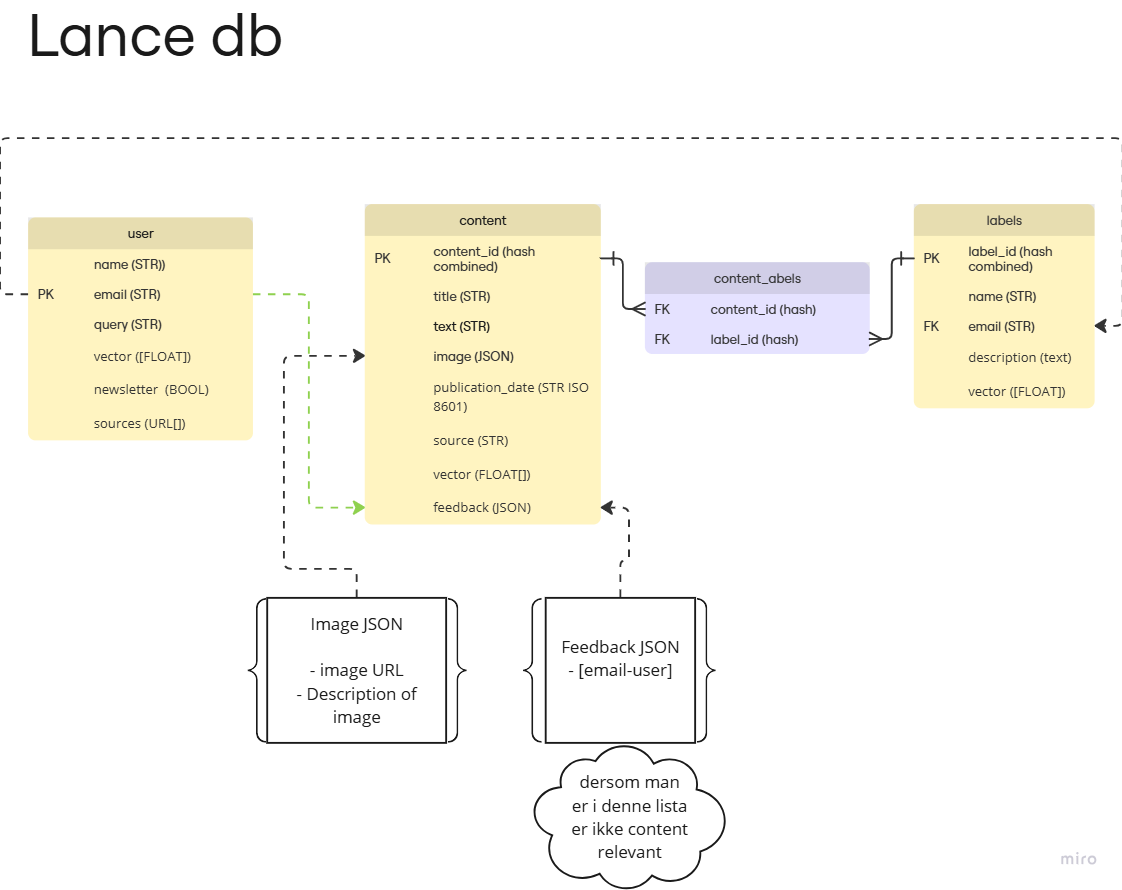


In [26]:
async def create_db():
    """
    Create the database schema for the local news AI application
    """
    # Initialize manager
    database_url = "az://dev-vector-db/"
    # Use default database URL and Azure credentials and embedder
    manager = LanceDBManager(database_url=database_url)
    # Create tables
    await manager.create_table("user", User)
    await manager.create_table("labels", Label)
    await manager.create_table("content_labels", ContentLabel)
await create_db()

ERROR:root:Error creating table 'user': Table 'user' already exists
ERROR:root:Error creating table 'labels': Table 'labels' already exists
ERROR:root:Error creating table 'content_labels': Table 'content_labels' already exists


## Add data to all current tables the lancedb database

example on how data is added to the tables.

it adds fake data to the tables.

## ways to do it

- you could add the data and type check it before adding it to the database manually, as well and making the embedding manually
  - make sure they are the same dimention embedding
- you could just send the array to the database and let it handle the type checking and embedding
  - there are some fields in the embeddings pydantic model which are defined to be the embeddings.SourceField()
  - TODO: check if we can have more than 1 source field in the model


In [23]:
async def add_db_schema():
    """
    Adds sample data to 'user', 'content', 'labels', and 'content_labels' tables using raw data and dynamically generates vectors.
    """
    credentials = DefaultAzureCredential()
    azure_credentials = {
        "azure_storage_account_name": "sadevlocalnewsai",
        "azure_tenant_id": "35971640-5c41-4de2-9579-823a95d4291e",
        "azure_storage_token": credentials.get_token("https://storage.azure.com/.default").token,
    }
    database_url = "az://dev-vector-db/"
    db_manager = LanceDBManager(
        database_url=database_url, azure_credentials=azure_credentials)
    # Raw data to be added to the 'user' table
    more_user_data = [
        {"email": "ai.dev@aenergi.no", "name": "AI GURU", "query": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b,abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19",
            "newsletter": True, "sources": ["https://vg.no"], "saved_content": ["9c0616f831e73e8abf7d7156bf7a96d8c7c9a24ac6ef397f23fde39c6faf58ae", "2eeafb71c187cec6e016e813c26a9845609777e7a01ae4b85391f47ee912b8b6",  "7111b305d1ce4d3cf93f1873a764186c49278547e03a62fe9e8e5cdfc0aac483", "dde3ca45d6a401559f823e8a461a5d90831aa5a43ea81d6ff4801396173130b6", "e289492e5ead24bf9bee7122bd0f534ec9a752f811575e7978a83e265bfe6906",  "11c55bed7f92287ff2d8c3e9d0cebd8b0add85c669663e093fcba14e85cfe74b"]},
    ]

    # Convert raw data to model instances and dynamically generate vectors for the 'query' field
    validated_users = []
    for data in tqdm(more_user_data):
        data["vector"] = embedder.generate_embeddings(
            [data["query"]])[0]  # Generate the embedding for the query
        validated_users.append(User(**data))

    # Add user data to database
    await db_manager.add_data("user", more_user_data, unique_field="email")

    # Raw data to be added to the 'content' table
    more_content_data = [
        {
            "content_id": "content_001",
            "title": "Greenstat Initiates 20-MW Green Hydrogen Plant in Kristiansand",
            "text": "Greenstat has commenced construction of a 20-MW green hydrogen plant in Kristiansand, marking the first phase of a larger industrial project aimed at expanding the site's capacity by an additional 40 MW.",

            "image_url": "https://renewablesnow.com/news/norways-greenstat-starts-building-20-mw-green-h2-plant-at-home-865842/",
            "image_description": "Greenstat's hydrogen plant construction site in Kristiansand",

            "publication_date": "2024-08-01T00:00:00Z",
            "source": "https://renewablesnow.com/news/norways-greenstat-starts-building-20-mw-green-h2-plant-at-home-865842/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_002",
            "title": "Norwegian Government Faces Pressure to Phase Out Oil Production",
            "text": "A state commission has recommended that the Norwegian government develop a strategy to phase out oil and gas production, urging a halt to new oil exploration licenses.",

            "image_url": "https://www.newsinenglish.no/2023/10/30/pressure-rises-to-phase-out-norways-oil/",
            "image_description": "Offshore oil platform in Norway",

            "publication_date": "2023-10-30T00:00:00Z",
            "source": "https://www.newsinenglish.no/2023/10/30/pressure-rises-to-phase-out-norways-oil/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_003",
            "title": "ELBE Eurocluster Promotes Offshore Renewable Energy Collaboration",
            "text": "The ELBE ALLIANCE, comprising eight European clusters, has become a Eurocluster to support offshore renewable energy projects, involving nearly 1,000 companies and R&D organizations.",
            "image_url": "https://gcenode.no/project/elbe-eurocluster/",
            "image_description": "Offshore wind turbines at sea",

            "publication_date": "2024-01-15T00:00:00Z",
            "source": "https://gcenode.no/project/elbe-eurocluster/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "7111b305d1ce4d3cf93f1873a764186c49278547e03a62fe9e8e5cdfc0aac483",
            "title": "Norwegian Government Addresses Wind Turbine Controversy",
            "text": "The government has stated there are no plans to dismantle wind turbines despite protests, emphasizing the importance of renewable energy sources in reducing oil and gas dependence.",

            "image_url": "https://www.newsinenglish.no/2023/03/24/no-plans-to-take-down-turbines/",
            "image_description": "Wind turbines in Norway",

            "publication_date": "2023-03-24T00:00:00Z",
            "source": "https://www.newsinenglish.no/2023/03/24/no-plans-to-take-down-turbines/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "dde3ca45d6a401559f823e8a461a5d90831aa5a43ea81d6ff4801396173130b6",
            "title": "Norseman Wind and EnBW Plan 1.5 GW Offshore Wind Project",
            "text": "Norseman Wind and EnBW have announced plans to develop a 1.5 GW offshore wind project, with Kristiansand serving as the head office for the initiative.",

            "image_url": "https://www.enbw.com/press/norseman-wind-and-enbw-plan-to-develop-1-5-gw-of-offshore-wind.html",
            "image_description": "Offshore wind farm visualization",

            "publication_date": "2024-02-10T00:00:00Z",
            "source": "https://www.enbw.com/press/norseman-wind-and-enbw-plan-to-develop-1-5-gw-of-offshore-wind.html",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_006",
            "title": "Norway Defines New Rules for Energy Communities",
            "text": "Norway's Ministry of Energy is establishing regulations to enable surplus renewable power from plants up to 5 MW to be shared within industrial areas, aiming to boost renewable energy without straining the power network.",

            "image_url": "https://www.pv-magazine.com/2024/12/10/norway-defining-new-rules-for-energy-communities/",
            "image_description": "Solar panels in an industrial area",

            "publication_date": "2024-12-10T00:00:00Z",
            "source": "https://www.pv-magazine.com/2024/12/10/norway-defining-new-rules-for-energy-communities/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_007",
            "title": "GCE NODE Supports Ocean Technology Cluster in Kristiansand",
            "text": "GCE NODE, an industry-driven cluster for ocean technologies based in Kristiansand, is actively promoting competence building and accelerating the transition to renewable energy.",

            "image_url": "https://gcenode.no/",
            "image_description": "GCE NODE headquarters in Kristiansand",

            "publication_date": "2024-12-22T00:00:00Z",
            "source": "https://gcenode.no/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_008",
            "title": "Greenstat and Everfuel Plan 60-MW Hydrogen Project in Kristiansand",
            "text": "Greenstat and Everfuel have announced plans to create a hydrogen hub in Kristiansand, starting with a 20-MW electrolysis capacity, to be expanded to 60 MW.",

            "image_url": "https://renewablesnow.com/news/greenstat-everfuel-plan-60-mw-hydrogen-project-in-norway-782361/",
            "image_description": "Hydrogen production facility concept",

            "publication_date": "2022-04-27T00:00:00Z",
            "source": "https://renewablesnow.com/news/greenstat-everfuel-plan-60-mw-hydrogen-project-in-norway-782361/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_009",
            "title": "Norway Participates in Global Climate Compromise",
            "text": "Norway has agreed to a global climate compromise, setting a clear direction for all countries to address climate change challenges and promote renewable energy.",

            "image_url": "https://www.newsinenglish.no/2023/12/18/norway-went-along-with-latest-climate-compromise/",
            "image_description": "Norwegian Prime Minister at climate summit",

            "publication_date": "2023-12-18T00:00:00Z",
            "source": "https://www.newsinenglish.no/2023/12/18/norway-went-along-with-latest-climate-compromise/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_010",
            "title": "Equinor Discusses Offshore Wind Plans in Kristiansand",
            "text": "Equinor has presented its offshore wind plans in Kristiansand, highlighting the most relevant areas for technology and system development in the renewable energy sector.",

            "image_url": "https://gcenode.no/news/talking-offshore-wind-with-equinor/",
            "image_description": "Equinor representatives discussing offshore wind",

            "publication_date": "2024-03-20T00:00:00Z",
            "source": "https://gcenode.no/news/talking-offshore-wind-with-equinor/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_011",
            "title": "Kristiansand Port Expands Green Shipping Initiatives",
            "text": "Kristiansand Port is advancing its green shipping initiatives by installing shore power facilities and promoting zero-emission solutions for cargo handling.",

            "image_url": "https://www.portofkristiansand.no/green-initiatives",
            "image_description": "Kristiansand Port with shore power installations",

            "publication_date": "2024-04-05T00:00:00Z",
            "source": "https://www.portofkristiansand.no/green-initiatives",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_012",
            "title": "Statkraft to Expand Wind Energy Production in Southern Norway",
            "text": "Statkraft has announced plans to expand its wind energy production capabilities in Southern Norway, with a significant focus on the Agder region.",

            "image_url": "https://www.statkraft.com/media/news/2024/statkraft-expands-wind-energy/",
            "image_description": "Wind turbines in Southern Norway",

            "publication_date": "2024-04-15T00:00:00Z",
            "source": "https://www.statkraft.com/media/news/2024/statkraft-expands-wind-energy/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_013",
            "title": "Kristiansand's Green City Plan Aims for Carbon Neutrality by 2030",
            "text": "Kristiansand has unveiled its Green City Plan, aiming for carbon neutrality by 2030 through extensive renewable energy integration and sustainable urban planning.",

            "image_url": "https://www.kristiansand.kommune.no/green-city-plan/",
            "image_description": "Kristiansand cityscape with green infrastructure",

            "publication_date": "2024-05-01T00:00:00Z",
            "source": "https://www.kristiansand.kommune.no/green-city-plan/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_014",
            "title": "Hydro Power Upgrades in Agder Region Boost Efficiency",
            "text": "Hydro power plants in the Agder region are undergoing upgrades to improve efficiency and increase clean energy output, aligning with Norway's renewable energy goals.",

            "image_url": "https://www.hydro.com/en/media/news/2024/hydro-upgrades-in-agder/",
            "image_description": "Hydropower plant in the Agder region",

            "publication_date": "2024-05-15T00:00:00Z",
            "source": "https://www.hydro.com/en/media/news/2024/hydro-upgrades-in-agder/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_015",
            "title": "University of Agder Launches Renewable Energy Research Center",
            "text": "The University of Agder has launched a new research center dedicated to exploring innovative renewable energy solutions for Southern Norway.",

            "image_url": "https://www.uia.no/news/renewable-energy-research-center",
            "image_description": "University of Agder's renewable energy research facility",

            "publication_date": "2024-06-01T00:00:00Z",
            "source": "https://www.uia.no/news/renewable-energy-research-center",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_016",
            "title": "Kristiansand's Electric Ferry Fleet Reduces Emissions",
            "text": "Kristiansand has expanded its electric ferry fleet, significantly reducing carbon emissions and promoting sustainable public transportation.",

            "image_url": "https://www.fjordline.com/news/electric-ferry-fleet-kristiansand/",
            "image_description": "Electric ferry docked at Kristiansand port",

            "publication_date": "2024-06-15T00:00:00Z",
            "source": "https://www.fjordline.com/news/electric-ferry-fleet-kristiansand/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_017",
            "title": "Enova Supports Energy Efficiency in Kristiansand's Industries",
            "text": "Enova has granted funding to Kristiansand-based industries to improve energy efficiency and reduce emissions in line with Norway's sustainability targets.",

            "image_url": "https://www.enova.no/news/2024/kristiansand-industries-energy-efficiency/",
            "image_description": "Kristiansand industrial facilities implementing energy solutions",

            "publication_date": "2024-07-01T00:00:00Z",
            "source": "https://www.enova.no/news/2024/kristiansand-industries-energy-efficiency/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_018",
            "title": "Agder Energi Invests in Smart Grid Technology",
            "text": "Agder Energi is investing in smart grid technology to enhance electricity distribution and support the integration of renewable energy sources.",

            "image_url": "https://www.ae.no/news/smart-grid-technology/",
            "image_description": "Smart grid control room at Agder Energi",

            "publication_date": "2024-07-15T00:00:00Z",
            "source": "https://www.ae.no/news/smart-grid-technology/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_019",
            "title": "Kristiansand Implements Energy-Efficient Street Lighting",
            "text": "Kristiansand has begun replacing traditional streetlights with energy-efficient LED lighting to cut down on energy use and emissions.",

            "image_url": "https://www.kristiansand.kommune.no/news/led-street-lighting/",
            "image_description": "LED street lights in Kristiansand",

            "publication_date": "2024-08-01T00:00:00Z",
            "source": "https://www.kristiansand.kommune.no/news/led-street-lighting/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        },
        {
            "content_id": "content_020",
            "title": "Norwegian Parliament Debates Carbon Tax Expansion",
            "text": "The Norwegian Parliament is debating the expansion of carbon taxes to accelerate the transition to renewable energy across the country.",

            "image_url": "https://www.stortinget.no/news/carbon-tax-debate/",
            "image_description": "Norwegian Parliament discussing carbon tax policies",

            "publication_date": "2024-08-15T00:00:00Z",
            "source": "https://www.stortinget.no/news/carbon-tax-debate/",
            "users": ["user@example.com", "ai.dev@aenergi.no"]
        }
    ]

    # you could also not validate as there are some fields that are default used for getting the embeddings

    # Add content data to database
    #await db_manager.add_data("content", more_content_data, unique_field="content_id")

    # Raw data to be added to the 'labels' table
    more_labels_data = [
        {
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b",
            "name": "åenergi kjøper fredrickstad",
            "email": "ai.dev@aenergi.no",
            "description": "alt å gjøre med fredrikstad og å energi"
        },
        {
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19",
            "name": "åenergi sparer strøm",
            "email": "ai.dev@aenergi.no",
            "description": "alt å gjøre med å energi, fornybær og energi politikk"
        }
    ]

    # Convert raw data to model instances and dynamically generate vectors for the 'description' field
    validated_labels = []
    for data in tqdm(more_labels_data):
        data["vector"] = embedder.generate_embeddings([data["description"]])[
            0]  # Generate the embedding for the description
        validated_labels.append(Label(**data))

    # Add label data to database
    await db_manager.add_data("labels", more_labels_data, unique_field="label_id")

    # Raw data to be added to the 'content_labels' relationship table
    more_content_labels_data = [
        {
            "content_id": "9c0616f831e73e8abf7d7156bf7a96d8c7c9a24ac6ef397f23fde39c6faf58ae",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "9c0616f831e73e8abf7d7156bf7a96d8c7c9a24ac6ef397f23fde39c6faf58ae",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "2eeafb71c187cec6e016e813c26a9845609777e7a01ae4b85391f47ee912b8b6",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "d9c2a99af00b3891c0f520fd2b765c01fef2235cc1ba1b86b6832331bf2682a9",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "7111b305d1ce4d3cf93f1873a764186c49278547e03a62fe9e8e5cdfc0aac483",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "dde3ca45d6a401559f823e8a461a5d90831aa5a43ea81d6ff4801396173130b6",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "e289492e5ead24bf9bee7122bd0f534ec9a752f811575e7978a83e265bfe6906",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "e289492e5ead24bf9bee7122bd0f534ec9a752f811575e7978a83e265bfe6906",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_007",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_008",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "content_009",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_010",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "content_011",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_012",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_013",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "content_014",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_015",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "content_015",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_016",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_017",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        },
        {
            "content_id": "content_018",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "content_019",
            "label_id": "abb305eb5a0a19cc3b5eee73f2510661deb6d4191be2c2a18a9f06190fcade19"
        },
        {
            "content_id": "11c55bed7f92287ff2d8c3e9d0cebd8b0add85c669663e093fcba14e85cfe74b",
            "label_id": "52e38cc5b14d213ed7388fbc6e4d05b5eda30115d2ae0d39af57f68fe6dd237b"
        }
    ]

    # Convert raw data to model instances and add to 'content_labels' relationship table
    validated_content_labels = [ContentLabel(
        **data) for data in tqdm(more_content_labels_data)]
    await db_manager.add_data("content_labels", more_content_labels_data, unique_field="label_id")

# Run the schema setup function
asyncio.run(add_db_schema())

100%|██████████| 23/23 [00:00<00:00, 62117.83it/s]


## Fetch data

example on how data is fetched from the tables


In [27]:
async def fetch_all_data():
    # Use default database URL and Azure credentials and embedder
    db_manager = LanceDBManager()
    # Fetch data from 'user' table
    user_df = await db_manager.fetch_data("user")
    # Fetch data from 'content' table
    content_df = await db_manager.fetch_data("content")
    # Fetch data from 'labels' table
    labels_df = await db_manager.fetch_data("labels")
    # Fetch data from 'content_labels' table
    content_labels_df = await db_manager.fetch_data("content_labels")
    return user_df, content_df, labels_df, content_labels_df

# Run the async functions
user_df, content_df, labels_df, content_labels_df = await fetch_all_data()

In [28]:
user_df

,email,name,query,vector,newsletter,sources,saved_content,_rowid


In [10]:
content_df[:20]

,content_id,title,text,vector,image_url,image_description,publication_date,source,users,_rowid
0,9c0616f831e73e8abf7d7156bf7a96d8c7c9a24ac6ef39...,Dystre drukningstall for juli i Norge – Rogala...,Dystre drukningstall for juli i Norge – Rogala...,"[0.02358469, -0.008165967, -0.010687226, -0.00...",https://example.com/default_image.jpg,No image description available,Unknown date,https://www.aftenbladet.no/lokalt/i/lwneM7/fae...,[],0
1,2eeafb71c187cec6e016e813c26a9845609777e7a01ae4...,Brakkebrann på Ålgård,Brakkebrann på Ålgård,"[0.012245649, 0.02589458, 0.0026295048, -0.014...",https://example.com/default_image.jpg,No image description available,Unknown date,https://www.aftenbladet.no/lokalt/i/93p1kq/bra...,[],1
2,d9c2a99af00b3891c0f520fd2b765c01fef2235cc1ba1b...,Stjal pakke som var levert til noen andre - ta...,Stjal pakke som var levert til noen andre - ta...,"[0.02438532, 0.029970478, -0.0016578793, -0.02...",https://example.com/default_image.jpg,No image description available,Unknown date,https://www.aftenbladet.no/lokalt/i/ny1xka/man...,[],2
3,7111b305d1ce4d3cf93f1873a764186c49278547e03a62...,Høstværet og styrtregn på vei: – Kan by på utf...,Høstværet og styrtregn på vei: – Kan by på utf...,"[-0.015045581, -0.015691007, -0.013267076, -0....",https://example.com/default_image.jpg,No image description available,Unknown date,https://www.aftenbladet.no/lokalt/i/kw0jqQ/vae...,[],3
4,dde3ca45d6a401559f823e8a461a5d90831aa5a43ea81d...,Kan hindre bygging av denne restauranten,Kan hindre bygging av denne restauranten,"[0.020721, -0.019108312, -0.00484145, -0.00042...",https://example.com/default_image.jpg,No image description available,Unknown date,https://www.aftenbladet.no/lokalt/i/73pAk3/kla...,[],4
5,e289492e5ead24bf9bee7122bd0f534ec9a752f811575e...,Opptur for to av tre Lysefjord-attraksjoner,Opptur for to av tre Lysefjord-attraksjoner,"[-0.016056582, 0.017227646, -0.010071146, -0.0...",https://premium.vgc.no/sa/images/61a2fded-f1d8...,,Unknown date,https://www.aftenbladet.no/lokalt/i/4B3exV/opp...,[],5
6,a1c62839da9ec8baf9d709bb289bf89b78554dff5b1286...,Mann utsatt for voldelig angrep – tre siktet,Mann utsatt for voldelig angrep – tre siktet,"[0.053101454, 0.033329915, -0.010590015, 0.003...",https://example.com/default_image.jpg,No image description available,Unknown date,https://www.aftenbladet.no/lokalt/i/LM4Owp/man...,[],6
7,2d36417bb35c1fb9ba0ccdc51c05aee92215d1ecb5327f...,Kjørte 124 km/t i 80-sonen,E39 Eiganestunnelen:Kjørte 124 km/t i 80-sonen,"[0.0074631986, 0.014859222, -0.013972506, -0.0...",https://example.com/default_image.jpg,No image description available,Unknown date,https://www.aftenbladet.no/lokalt/i/ny1jRx/e39...,[],7
8,e84ef5b137a7b03edc1391beea2fe1053b142ea6e501f5...,MC-fører mistenkt for å være ruspåvirket,MC-fører mistenkt for å være ruspåvirket,"[0.03664483, 0.00071983464, -0.01079841, -0.02...",https://example.com/default_image.jpg,No image description available,Unknown date,https://www.aftenbladet.no/lokalt/i/93pd7w/mc-...,[],8
9,11c55bed7f92287ff2d8c3e9d0cebd8b0add85c669663e...,Kran gikk i bakken ved Jåttå,Kran gikk i bakken ved Jåttå,"[0.01545657, 0.019816808, 0.0013786046, -0.012...",https://premium.vgc.no/sa/images/b29bec89-9871...,,Unknown date,https://www.aftenbladet.no/lokalt/i/W0v57g/uly...,[],9


In [11]:
content_df
# print only the contend_id and title
content_df[["content_id"]]

,content_id
0,9c0616f831e73e8abf7d7156bf7a96d8c7c9a24ac6ef39...
1,2eeafb71c187cec6e016e813c26a9845609777e7a01ae4...
2,d9c2a99af00b3891c0f520fd2b765c01fef2235cc1ba1b...
3,7111b305d1ce4d3cf93f1873a764186c49278547e03a62...
4,dde3ca45d6a401559f823e8a461a5d90831aa5a43ea81d...
5,e289492e5ead24bf9bee7122bd0f534ec9a752f811575e...
6,a1c62839da9ec8baf9d709bb289bf89b78554dff5b1286...
7,2d36417bb35c1fb9ba0ccdc51c05aee92215d1ecb5327f...
8,e84ef5b137a7b03edc1391beea2fe1053b142ea6e501f5...
9,11c55bed7f92287ff2d8c3e9d0cebd8b0add85c669663e...


In [12]:
labels_df

,label_id,name,email,description,vector,_rowid


In [29]:
content_labels_df

,content_label_id,content_id,label_id,active,_rowid


## Vector search

find the most similar vectors in the database


In [ ]:
async def vector_search_data():
    # Use default database URL and Azure credentials and embedder
    db_manager = LanceDBManager()

    # Perform a vector search
    results = await db_manager.vector_search("content", query="Text 3", limit=50)
    print("Search Results:", results)
await vector_search_data()